In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
from pylab import plot, show, savefig
from scipy import stats
#%pylab inline

In [4]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-05-19/"
#path = "/Users/marf 1/Desktop/PhD Temp/2016-07-25/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 4094
files_end = 4172


In [58]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111", "Te" : "126", "Xe" : "129"}
#corr_isotopes_2 = {}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
# 122/118 norm
#isotopes = [["111", "112", "113", "114", "115", "116", "117", "119", "120", "122", "124", "125"]]
#isotope_column = ["111", "112", "113", "114", "115", "116", "117", "119", "120", "122", "124", "125"]
#data_sample_column = [(i + "/" + "118") for i in isotope_column]
#denom_isotope = "118"
#norm_ratio = ["122","118"]
# 116/120 norm
isotopes = [["111", "112", "113", "114", "115", "116", "117", "118", "119", "122", "124", "125"]]
isotope_column = ["111", "112", "113", "114", "115", "116", "117", "118", "119", "122", "124", "125"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
denom_isotope = "120"
norm_ratio = ["116","120"]

#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = False
# background correction
blk_corr = True

In [16]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
#files_1 = range(files_start, files_end, 1)
files_1 = range(4094, 4098, 1) + range(4099, 4172, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    #df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all
#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(4544)
df_all

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),...,H5 (2),H4 (2),H3 (2),H2 (2),H1 (2),Ax (2),L1 (2),L2 (2),L3 (2),L4 (2)
date,,,,,,,,,,,,,,,,,,,,,
2016-05-19 16:42:00,1,blank sol,0.000769,0.000527,0.005146,0.001031,0.002878,0.000892,0.002243,0.000062,...,0.000071,-1.573900e-06,0.000782,7.680700e-05,0.000554,0.000075,0.005079,0.001051,0.002899,0.000906
2016-05-19 16:42:00,2,blank sol,0.000842,0.000600,0.005499,0.001090,0.003130,0.000995,0.002376,0.000074,...,0.000079,3.913600e-05,0.000775,7.034210e-05,0.000576,0.000083,0.005116,0.001032,0.002897,0.000911
2016-05-19 16:42:00,3,blank sol,0.000861,0.000640,0.005531,0.001127,0.003176,0.001007,0.002394,0.000068,...,0.000076,7.707700e-06,0.000763,4.520830e-05,0.000569,0.000079,0.005157,0.001018,0.002900,0.000913
2016-05-19 16:42:00,4,blank sol,0.000873,0.000616,0.005674,0.001142,0.003254,0.001035,0.002499,0.000051,...,0.000072,1.056400e-05,0.000856,5.813220e-05,0.000644,0.000096,0.005660,0.001196,0.003287,0.001048
2016-05-19 16:42:00,5,blank sol,0.000813,0.000600,0.005478,0.001087,0.003070,0.000990,0.002363,0.000072,...,0.000044,2.842250e-05,0.000808,6.100690e-05,0.000623,0.000040,0.005361,0.001099,0.003074,0.000961
2016-05-19 16:42:00,6,blank sol,0.000730,0.000544,0.004932,0.000944,0.002710,0.000859,0.002177,0.000043,...,0.000063,-1.571900e-06,0.000859,3.587680e-05,0.000649,0.000065,0.005430,0.001135,0.003096,0.000989
2016-05-19 16:42:00,7,blank sol,0.000810,0.000569,0.005213,0.001069,0.002883,0.000955,0.002276,0.000080,...,0.000073,8.425400e-06,0.001015,5.885430e-05,0.000774,0.000062,0.006472,0.001414,0.003889,0.001231
2016-05-19 16:42:00,8,blank sol,0.000746,0.000563,0.005067,0.001014,0.002791,0.000887,0.003720,0.000075,...,0.000085,1.342660e-05,0.000691,5.093010e-05,0.000478,0.000073,0.004605,0.000912,0.002501,0.000824
2016-05-19 16:42:00,9,blank sol,0.000768,0.000541,0.004993,0.001015,0.002774,0.000908,0.002176,0.000076,...,0.000081,2.271220e-05,0.000833,5.023850e-05,0.000603,0.000044,0.005463,0.001133,0.003128,0.001002


,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),...,H5 (2),H4 (2),H3 (2),H2 (2),H1 (2),Ax (2),L1 (2),L2 (2),L3 (2),L4 (2)
date,,,,,,,,,,,,,,,,,,,,,
2016-05-19 16:42:00,1,blank sol,0.000769,0.000527,0.005146,0.001031,0.002878,0.000892,0.002243,0.000062,...,0.000071,-1.573900e-06,0.000782,7.680700e-05,0.000554,0.000075,0.005079,0.001051,0.002899,0.000906
2016-05-19 16:42:00,2,blank sol,0.000842,0.000600,0.005499,0.001090,0.003130,0.000995,0.002376,0.000074,...,0.000079,3.913600e-05,0.000775,7.034210e-05,0.000576,0.000083,0.005116,0.001032,0.002897,0.000911
2016-05-19 16:42:00,3,blank sol,0.000861,0.000640,0.005531,0.001127,0.003176,0.001007,0.002394,0.000068,...,0.000076,7.707700e-06,0.000763,4.520830e-05,0.000569,0.000079,0.005157,0.001018,0.002900,0.000913
2016-05-19 16:42:00,4,blank sol,0.000873,0.000616,0.005674,0.001142,0.003254,0.001035,0.002499,0.000051,...,0.000072,1.056400e-05,0.000856,5.813220e-05,0.000644,0.000096,0.005660,0.001196,0.003287,0.001048
2016-05-19 16:42:00,5,blank sol,0.000813,0.000600,0.005478,0.001087,0.003070,0.000990,0.002363,0.000072,...,0.000044,2.842250e-05,0.000808,6.100690e-05,0.000623,0.000040,0.005361,0.001099,0.003074,0.000961
2016-05-19 16:42:00,6,blank sol,0.000730,0.000544,0.004932,0.000944,0.002710,0.000859,0.002177,0.000043,...,0.000063,-1.571900e-06,0.000859,3.587680e-05,0.000649,0.000065,0.005430,0.001135,0.003096,0.000989
2016-05-19 16:42:00,7,blank sol,0.000810,0.000569,0.005213,0.001069,0.002883,0.000955,0.002276,0.000080,...,0.000073,8.425400e-06,0.001015,5.885430e-05,0.000774,0.000062,0.006472,0.001414,0.003889,0.001231
2016-05-19 16:42:00,8,blank sol,0.000746,0.000563,0.005067,0.001014,0.002791,0.000887,0.003720,0.000075,...,0.000085,1.342660e-05,0.000691,5.093010e-05,0.000478,0.000073,0.004605,0.000912,0.002501,0.000824
2016-05-19 16:42:00,9,blank sol,0.000768,0.000541,0.004993,0.001015,0.002774,0.000908,0.002176,0.000076,...,0.000081,2.271220e-05,0.000833,5.023850e-05,0.000603,0.000044,0.005463,0.001133,0.003128,0.001002


In [59]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        #df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        #df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    data_sample = new_corr.internal_norm_1(norm_ratio, denom_isotope, iter_beta)
    #data_sample = new_corr.raw_ratios_corr(denom_isotope)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = new_corr.mad_outlier_rejection(data_sample)
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)

[set(['131', '115', '121', '117', '111', '125', '127', '129', '119', '118']), set(['113', '114', '116', '110', '126', '112']), set(['120', '122', '123', '124'])]
[set(['131', '115', '121', '117', '111', '125', '127', '129', '119', '118']), set(['113', '114', '116', '110', '126', '112']), set(['120', '122', '123', '124'])]
[set(['131', '115', '121', '117', '111', '125', '127', '129', '119', '118']), set(['113', '114', '116', '110', '126', '112']), set(['120', '122', '123', '124'])]
[set(['131', '115', '121', '117', '111', '125', '127', '129', '119', '118']), set(['113', '114', '116', '110', '126', '112']), set(['120', '122', '123', '124'])]
[set(['131', '115', '121', '117', '111', '125', '127', '129', '119', '118']), set(['113', '114', '116', '110', '126', '112']), set(['120', '122', '123', '124'])]
[set(['131', '115', '121', '117', '111', '125', '127', '129', '119', '118']), set(['113', '114', '116', '110', '126', '112']), set(['120', '122', '123', '124'])]
[set(['131', '115', '121', '

KeyboardInterrupt: 

In [46]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
df_internal_sub["Te/Sn"] = (df_internal_norm["125"]/7.0509)/(df_internal_norm["118"]/24.223)
#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.952)/(df_internal_norm["118"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [47]:
df_internal_norm

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,114,117,116,111,125,113,112,124,119,118
date,,,,,,,,,,,,,,,,,,,,,
2016-05-19 16:52:00,-0.000021,0.029823,NaN,0.020199,0.010357,NaN,0.235293,0.742965,0.263482,0.142100,...,0.370714,4.511226,8.434594,-0.000378,0.000124,-0.000375,0.532664,3.735371,5.189945,14.438888
2016-05-19 16:52:00,-0.000019,0.029825,2.278859e-06,0.020192,0.010359,0.446,0.235303,0.742975,0.263472,0.142089,...,0.388649,4.729525,8.842810,-0.000356,0.000144,-0.000301,0.558659,3.914424,5.440132,15.136390
2016-05-19 16:52:00,-0.000018,0.029824,3.636615e-06,0.020192,0.010360,NaN,0.235303,0.742966,0.263466,0.142096,...,0.380272,4.626683,8.650654,-0.000322,0.000163,-0.000244,0.546583,3.828956,5.321619,14.806963
2016-05-19 16:52:00,NaN,0.029819,2.410894e-06,0.020190,0.010363,0.446,0.235297,0.742963,0.263478,0.142101,...,0.390936,4.740900,8.864730,NaN,0.000168,NaN,0.561071,3.924148,5.453423,15.172851
2016-05-19 16:52:00,NaN,0.029826,NaN,NaN,0.010365,NaN,0.235301,0.742956,0.263465,0.142094,...,0.399670,4.745852,8.875944,NaN,0.000152,NaN,0.568431,3.927831,5.458785,15.188383
2016-05-19 16:52:00,NaN,0.029822,2.134749e-06,0.020195,0.010360,0.446,0.235308,0.742969,0.263468,0.142097,...,0.370897,4.502136,8.417663,NaN,0.000163,0.000087,0.532464,3.726283,5.178460,14.408345
2016-05-19 16:52:00,-0.000003,0.029822,2.922099e-06,0.020194,0.010360,NaN,0.235296,0.742944,0.263477,0.142100,...,0.396518,4.816227,9.005512,-0.000064,0.000162,-0.000005,0.569471,3.986158,5.539948,15.413465
2016-05-19 16:52:00,NaN,0.029822,2.713016e-06,0.020194,0.010364,0.446,0.235298,0.742965,0.263464,0.142096,...,0.387337,4.684483,8.759415,NaN,0.000173,NaN,0.555253,3.877012,5.388238,14.992302
2016-05-19 16:52:00,-0.000012,0.029818,1.045661e-07,0.020189,0.010362,0.446,0.235307,0.742947,0.263468,0.142098,...,0.384068,4.671325,8.733863,-0.000227,0.000135,-0.000218,0.551861,3.866569,5.373119,14.949487


,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,114,117,116,111,125,113,112,124,119,118
date,,,,,,,,,,,,,,,,,,,,,
2016-05-19 16:52:00,-0.000021,0.029823,NaN,0.020199,0.010357,NaN,0.235293,0.742965,0.263482,0.142100,...,0.370714,4.511226,8.434594,-0.000378,0.000124,-0.000375,0.532664,3.735371,5.189945,14.438888
2016-05-19 16:52:00,-0.000019,0.029825,2.278859e-06,0.020192,0.010359,0.446,0.235303,0.742975,0.263472,0.142089,...,0.388649,4.729525,8.842810,-0.000356,0.000144,-0.000301,0.558659,3.914424,5.440132,15.136390
2016-05-19 16:52:00,-0.000018,0.029824,3.636615e-06,0.020192,0.010360,NaN,0.235303,0.742966,0.263466,0.142096,...,0.380272,4.626683,8.650654,-0.000322,0.000163,-0.000244,0.546583,3.828956,5.321619,14.806963
2016-05-19 16:52:00,NaN,0.029819,2.410894e-06,0.020190,0.010363,0.446,0.235297,0.742963,0.263478,0.142101,...,0.390936,4.740900,8.864730,NaN,0.000168,NaN,0.561071,3.924148,5.453423,15.172851
2016-05-19 16:52:00,NaN,0.029826,NaN,NaN,0.010365,NaN,0.235301,0.742956,0.263465,0.142094,...,0.399670,4.745852,8.875944,NaN,0.000152,NaN,0.568431,3.927831,5.458785,15.188383
2016-05-19 16:52:00,NaN,0.029822,2.134749e-06,0.020195,0.010360,0.446,0.235308,0.742969,0.263468,0.142097,...,0.370897,4.502136,8.417663,NaN,0.000163,0.000087,0.532464,3.726283,5.178460,14.408345
2016-05-19 16:52:00,-0.000003,0.029822,2.922099e-06,0.020194,0.010360,NaN,0.235296,0.742944,0.263477,0.142100,...,0.396518,4.816227,9.005512,-0.000064,0.000162,-0.000005,0.569471,3.986158,5.539948,15.413465
2016-05-19 16:52:00,NaN,0.029822,2.713016e-06,0.020194,0.010364,0.446,0.235298,0.742965,0.263464,0.142096,...,0.387337,4.684483,8.759415,NaN,0.000173,NaN,0.555253,3.877012,5.388238,14.992302
2016-05-19 16:52:00,-0.000012,0.029818,1.045661e-07,0.020189,0.010362,0.446,0.235307,0.742947,0.263468,0.142098,...,0.384068,4.671325,8.733863,-0.000227,0.000135,-0.000218,0.551861,3.866569,5.373119,14.949487


In [48]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SD2])
df_internal_norm_mean["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
#df_internal_norm_mean = df_internal_norm_mean[1:]
#df_internal_norm_mean = df_internal_norm_mean.drop(datetime.strptime("20150310 23:59", "%Y%m%d %H:%M"))
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
df_internal_norm_mean
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2016-05-19 16:52:00,-1.543918e-05,0.029822,2.158450e-06,0.020192,0.010361,0.446,0.235303,0.742959,0.263471,0.142095,...,4.620584,14.787556,5.314890,20.442166,2.982089,3.824527,0.000156,-3.590527e-05,0.000036,NIST 200ppb
2016-05-19 17:16:00,-3.726898e-06,0.029820,7.684580e-07,0.020190,0.010360,0.446,0.235305,0.742972,0.263472,0.142099,...,8.249312,26.401130,9.488938,36.496364,5.324242,6.828515,0.000262,-8.666999e-06,0.000034,NIST 350ppb
2016-05-19 17:49:00,-9.467533e-06,0.029819,-6.802428e-07,0.020189,0.010361,0.446,0.235305,0.742962,0.263470,0.142095,...,4.411214,14.119698,5.075617,19.524969,2.849179,3.655210,0.000155,-2.199380e-05,0.000038,NIST 200ppb
2016-05-19 18:13:00,-5.890402e-06,0.029823,1.006397e-06,0.020192,0.010360,0.446,0.235298,0.742957,0.263464,0.142094,...,4.472305,14.316156,5.146376,19.798500,2.889322,3.707116,0.000151,-1.367932e-05,0.000036,NIST 200ppb
2016-05-19 18:27:00,-7.107037e-06,0.029821,1.547530e-06,0.020191,0.010360,0.446,0.235302,0.742961,0.263468,0.142095,...,4.419418,14.146283,5.085209,19.562344,2.854707,3.662480,0.000148,-1.847827e-05,0.000036,NIST 200ppb
2016-05-19 18:41:00,-1.061430e-06,0.029823,2.119714e-06,0.020194,0.010360,0.446,0.235303,0.742963,0.263466,0.142097,...,4.317081,13.819098,4.967677,19.110813,2.788989,3.578386,0.000143,-2.465267e-06,0.000036,NIST 200ppb
2016-05-19 18:55:00,-3.999559e-06,0.029821,1.182166e-06,0.020191,0.010359,0.446,0.235301,0.742963,0.263470,0.142101,...,7.985431,25.562268,9.189392,35.352009,5.159532,6.620188,0.000271,-9.286743e-06,0.000036,NIST 350ppb
2016-05-19 19:09:00,-1.318248e-05,0.029822,1.054224e-06,0.020191,0.010360,0.446,0.235302,0.742953,0.263464,0.142096,...,4.312776,13.806003,4.963305,19.095298,2.787042,3.576277,0.000141,-3.060015e-05,0.000035,NIST 200ppb
2016-05-19 19:33:00,-5.280968e-06,0.029823,2.212231e-06,0.020194,0.010360,0.446,0.235300,0.742957,0.263465,0.142099,...,4.266756,13.659630,4.910941,18.894786,2.758136,3.539546,0.000147,-1.225376e-05,0.000037,NIST 200ppb


,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2016-05-19 16:52:00,-1.543918e-05,0.029822,2.158450e-06,0.020192,0.010361,0.446,0.235303,0.742959,0.263471,0.142095,...,4.620584,14.787556,5.314890,20.442166,2.982089,3.824527,0.000156,-3.590527e-05,0.000036,NIST 200ppb
2016-05-19 17:16:00,-3.726898e-06,0.029820,7.684580e-07,0.020190,0.010360,0.446,0.235305,0.742972,0.263472,0.142099,...,8.249312,26.401130,9.488938,36.496364,5.324242,6.828515,0.000262,-8.666999e-06,0.000034,NIST 350ppb
2016-05-19 17:49:00,-9.467533e-06,0.029819,-6.802428e-07,0.020189,0.010361,0.446,0.235305,0.742962,0.263470,0.142095,...,4.411214,14.119698,5.075617,19.524969,2.849179,3.655210,0.000155,-2.199380e-05,0.000038,NIST 200ppb
2016-05-19 18:13:00,-5.890402e-06,0.029823,1.006397e-06,0.020192,0.010360,0.446,0.235298,0.742957,0.263464,0.142094,...,4.472305,14.316156,5.146376,19.798500,2.889322,3.707116,0.000151,-1.367932e-05,0.000036,NIST 200ppb
2016-05-19 18:27:00,-7.107037e-06,0.029821,1.547530e-06,0.020191,0.010360,0.446,0.235302,0.742961,0.263468,0.142095,...,4.419418,14.146283,5.085209,19.562344,2.854707,3.662480,0.000148,-1.847827e-05,0.000036,NIST 200ppb
2016-05-19 18:41:00,-1.061430e-06,0.029823,2.119714e-06,0.020194,0.010360,0.446,0.235303,0.742963,0.263466,0.142097,...,4.317081,13.819098,4.967677,19.110813,2.788989,3.578386,0.000143,-2.465267e-06,0.000036,NIST 200ppb
2016-05-19 18:55:00,-3.999559e-06,0.029821,1.182166e-06,0.020191,0.010359,0.446,0.235301,0.742963,0.263470,0.142101,...,7.985431,25.562268,9.189392,35.352009,5.159532,6.620188,0.000271,-9.286743e-06,0.000036,NIST 350ppb
2016-05-19 19:09:00,-1.318248e-05,0.029822,1.054224e-06,0.020191,0.010360,0.446,0.235302,0.742953,0.263464,0.142096,...,4.312776,13.806003,4.963305,19.095298,2.787042,3.576277,0.000141,-3.060015e-05,0.000035,NIST 200ppb
2016-05-19 19:33:00,-5.280968e-06,0.029823,2.212231e-06,0.020194,0.010360,0.446,0.235300,0.742957,0.263465,0.142099,...,4.266756,13.659630,4.910941,18.894786,2.758136,3.539546,0.000147,-1.225376e-05,0.000037,NIST 200ppb


In [49]:
df_internal_norm_sample_sd = df_internal_norm_mean.groupby(df_internal_norm_mean["sample"]).agg([np.mean, SD2])
df_internal_norm_sample_sd

111/120             112/120                \
                                  mean       SD2      mean           SD2   
sample                                                                     
Allende HP 1_1            5.360235e-06  0.000000  0.029821  0.000000e+00   
Allende bomb 1_1          1.206636e-05  0.000000  0.029824  0.000000e+00   
NIST + Cd ns 1            4.511983e-06  0.000000  0.029823  0.000000e+00   
NIST 200ppb              -7.211489e-06  0.000017  0.029823  2.631741e-06   
NIST 200ppb + 0.005ppb U -5.549818e-06  0.000011  0.029824  7.220227e-07   
NIST 200ppb + 0.02ppb Mo  9.058139e-07  0.000006  0.029823  7.342048e-07   
NIST 200ppb + 0.03ppb Cd  2.072908e-05  0.000047  0.029823  1.837402e-06   
NIST 200ppb + 0.6ppb Pd  -7.858109e-06  0.000015  0.029824  8.875620e-07   
NIST 350ppb              -4.358151e-06  0.000009  0.029821  1.679310e-06   
ZH09-05 23.3_1_3          1.412389e-06  0.000000  0.029825  0.000000e+00   
ZH09-05 23.3_1_4         -2.801069e-07  0.000000  0.029823  0.000000e+00   
ZH09-05 44.8_1_2         -4.085761e-06  0.000000  0.029823  0.000000e+00   

                               113/120                 114/120                \
                                  mean           SD2      mean           SD2   
sample                                                                         
Allende HP 1_1            5.806238e-07  0.000000e+00  0.020190  0.000000e+00   
Allende bomb 1_1          2.034820e-06  0.000000e+00  0.020193  0.000000e+00   
NIST + Cd ns 1           -2.242884e-07  0.000000e+00  0.020191  0.000000e+00   
NIST 200ppb               8.383681e-07  1.785516e-06  0.020191  3.191331e-06   
NIST 200ppb + 0.005ppb U  1.296747e-06  2.118648e-07  0.020192  1.074866e-07   
NIST 200ppb + 0.02ppb Mo  8.364912e-07  1.690816e-06  0.020191  3.614719e-07   
NIST 200ppb + 0.03ppb Cd  1.088708e-06  1.270213e-06  0.020192  3.434606e-06   
NIST 200ppb + 0.6ppb Pd   1.263348e-06  8.759216e-07  0.020192  2.035865e-06   
NIST 350ppb               8.495767e-07  7.794040e-07  0.020190  9.720470e-07   
ZH09-05 23.3_1_3          1.192136e-06  0.000000e+00  0.020192  0.000000e+00   
ZH09-05 23.3_1_4          9.406627e-07  0.000000e+00  0.020190  0.000000e+00   
ZH09-05 44.8_1_2          8.829562e-07  0.000000e+00  0.020190  0.000000e+00   

                           115/120                    ...            122  \
                              mean           SD2      ...           mean   
sample                                                ...                  
Allende HP 1_1            0.010359  0.000000e+00      ...       2.991284   
Allende bomb 1_1          0.010358  0.000000e+00      ...       2.896039   
NIST + Cd ns 1            0.010359  0.000000e+00      ...       3.095921   
NIST 200ppb               0.010360  1.567587e-06      ...       2.755755   
NIST 200ppb + 0.005ppb U  0.010359  8.886264e-07      ...       2.626560   
NIST 200ppb + 0.02ppb Mo  0.010361  1.213605e-06      ...       2.687758   
NIST 200ppb + 0.03ppb Cd  0.010359  2.806788e-06      ...       2.606322   
NIST 200ppb + 0.6ppb Pd   0.010360  6.371436e-07      ...       2.647541   
NIST 350ppb               0.010360  1.209146e-06      ...       5.109768   
ZH09-05 23.3_1_3          0.010358  0.000000e+00      ...       2.729474   
ZH09-05 23.3_1_4          0.010359  0.000000e+00      ...       2.713374   
ZH09-05 44.8_1_2          0.010359  0.000000e+00      ...       3.051678   

                                         124                 125            \
                               SD2      mean       SD2      mean       SD2   
sample                                                                       
Allende HP 1_1            0.000000  3.840789  0.000000  0.000135  0.000000   
Allende bomb 1_1          0.000000  3.718719  0.000000  0.000149  0.000000   
NIST + Cd ns 1            0.000000  3.974954  0.000000  0.000147  0.000000   
NIST 200ppb               0.226477  3.537808  0.289524  0.000143  0.000019   
NI

111/120             112/120                \
                                  mean       SD2      mean           SD2   
sample                                                                     
Allende HP 1_1            5.360235e-06  0.000000  0.029821  0.000000e+00   
Allende bomb 1_1          1.206636e-05  0.000000  0.029824  0.000000e+00   
NIST + Cd ns 1            4.511983e-06  0.000000  0.029823  0.000000e+00   
NIST 200ppb              -7.211489e-06  0.000017  0.029823  2.631741e-06   
NIST 200ppb + 0.005ppb U -5.549818e-06  0.000011  0.029824  7.220227e-07   
NIST 200ppb + 0.02ppb Mo  9.058139e-07  0.000006  0.029823  7.342048e-07   
NIST 200ppb + 0.03ppb Cd  2.072908e-05  0.000047  0.029823  1.837402e-06   
NIST 200ppb + 0.6ppb Pd  -7.858109e-06  0.000015  0.029824  8.875620e-07   
NIST 350ppb              -4.358151e-06  0.000009  0.029821  1.679310e-06   
ZH09-05 23.3_1_3          1.412389e-06  0.000000  0.029825  0.000000e+00   
ZH09-05 23.3_1_4         -2.801069e-07  0.000000  0.029823  0.000000e+00   
ZH09-05 44.8_1_2         -4.085761e-06  0.000000  0.029823  0.000000e+00   

                               113/120                 114/120                \
                                  mean           SD2      mean           SD2   
sample                                                                         
Allende HP 1_1            5.806238e-07  0.000000e+00  0.020190  0.000000e+00   
Allende bomb 1_1          2.034820e-06  0.000000e+00  0.020193  0.000000e+00   
NIST + Cd ns 1           -2.242884e-07  0.000000e+00  0.020191  0.000000e+00   
NIST 200ppb               8.383681e-07  1.785516e-06  0.020191  3.191331e-06   
NIST 200ppb + 0.005ppb U  1.296747e-06  2.118648e-07  0.020192  1.074866e-07   
NIST 200ppb + 0.02ppb Mo  8.364912e-07  1.690816e-06  0.020191  3.614719e-07   
NIST 200ppb + 0.03ppb Cd  1.088708e-06  1.270213e-06  0.020192  3.434606e-06   
NIST 200ppb + 0.6ppb Pd   1.263348e-06  8.759216e-07  0.020192  2.035865e-06   
NIST 350ppb               8.495767e-07  7.794040e-07  0.020190  9.720470e-07   
ZH09-05 23.3_1_3          1.192136e-06  0.000000e+00  0.020192  0.000000e+00   
ZH09-05 23.3_1_4          9.406627e-07  0.000000e+00  0.020190  0.000000e+00   
ZH09-05 44.8_1_2          8.829562e-07  0.000000e+00  0.020190  0.000000e+00   

                           115/120                    ...            122  \
                              mean           SD2      ...           mean   
sample                                                ...                  
Allende HP 1_1            0.010359  0.000000e+00      ...       2.991284   
Allende bomb 1_1          0.010358  0.000000e+00      ...       2.896039   
NIST + Cd ns 1            0.010359  0.000000e+00      ...       3.095921   
NIST 200ppb               0.010360  1.567587e-06      ...       2.755755   
NIST 200ppb + 0.005ppb U  0.010359  8.886264e-07      ...       2.626560   
NIST 200ppb + 0.02ppb Mo  0.010361  1.213605e-06      ...       2.687758   
NIST 200ppb + 0.03ppb Cd  0.010359  2.806788e-06      ...       2.606322   
NIST 200ppb + 0.6ppb Pd   0.010360  6.371436e-07      ...       2.647541   
NIST 350ppb               0.010360  1.209146e-06      ...       5.109768   
ZH09-05 23.3_1_3          0.010358  0.000000e+00      ...       2.729474   
ZH09-05 23.3_1_4          0.010359  0.000000e+00      ...       2.713374   
ZH09-05 44.8_1_2          0.010359  0.000000e+00      ...       3.051678   

                                         124                 125            \
                               SD2      mean       SD2      mean       SD2   
sample                                                                       
Allende HP 1_1            0.000000  3.840789  0.000000  0.000135  0.000000   
Allende bomb 1_1          0.000000  3.718719  0.000000  0.000149  0.000000   
NIST + Cd ns 1            0.000000  3.974954  0.000000  0.000147  0.000000   
NIST 200ppb               0.226477  3.537808  0.289524  0.000143  0.000019   
NI

In [50]:
plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 200ppb"]
plot_Nist = plot_Nist[(plot_Nist["118"] >= .5)]
#dataplot = plot(plot_Nist["Te/Sn"], plot_Nist["124/118"], "ro")
dataplot = plot(plot_Nist.index, plot_Nist["112/120"], "ro")
#dataplot = plot(plot_Nist.index, plot_Nist["120"], "ro")
show(dataplot)

In [388]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "NIST 200ppb")].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_internal_norm_mean[df_internal_norm_mean["118"] >= 1]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
std_mean = corr_values[(corr_values["sample"] == "NIST 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
epsilon_2 = ((new / ((new.shift(2) + new.shift(-2))/2))-1)*10000
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#new[new.sample != "NIST 100ppb"]
epsilon_2 = epsilon_2[epsilon_2["sample"] == "NIST 200ppb"]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=True)
epsilon_comp

,111/120,112/120,113/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,...,117,118,119,120,122,124,125,Cd/Sn,Te/Sn,sample
0,362.329217,-0.182942,-882.254909,-0.233228,-0.095279,-1.110223e-12,0.086080,0.027675,-0.088512,0.122797,...,8.588001,8.406764,8.177519,8.134346,8.003869,7.638580,-378.989054,242.125013,-387.220812,NIST 200ppb
1,-3259.040858,0.430088,2670.219749,1.021581,0.329577,0.000000e+00,0.059233,0.213634,0.311160,0.462492,...,8356.674247,8356.561742,8356.358506,8355.401444,8355.505392,8355.051423,8575.598164,-3219.981836,132.827249,NIST 350ppb
2,112.978551,0.118278,-1425.735748,0.257617,-0.140813,-1.110223e-12,0.032641,-0.018987,-0.010695,-0.195709,...,67.867674,67.788014,67.761724,67.748242,67.547006,67.425812,43.724495,45.185571,-12.013105,NIST 200ppb + 0.056ppb Zr
3,-3116.499887,0.067410,2107.120684,1.248227,0.514317,2.220446e-12,0.028722,0.196434,0.329184,0.619553,...,8629.684094,8629.556182,8629.365689,8628.317423,8628.601672,8628.054605,8571.192776,-3160.809560,-27.490793,NIST 350ppb
4,382.678949,-0.480560,-1324.347825,-0.741880,1.032789,0.000000e+00,0.118576,0.002410,-0.083907,-0.157182,...,-2.315794,-2.428628,-2.417227,-2.350148,-2.421349,-2.326855,-679.738908,382.458347,-694.845117,NIST 200ppb + 0.440ppb Mo
5,-339.342729,-0.396560,1051.807120,0.611738,1.568781,-1.110223e-12,0.063779,0.019516,0.093208,0.071425,...,266.869203,266.901663,267.031401,266.936741,267.070060,267.143668,547.132576,-339.478068,271.702206,NIST 200ppb + 0.250ppb Pd
6,839.566093,-0.787000,-2292.579456,-1.291168,-0.608685,-1.110223e-12,-0.110179,0.093893,0.192232,0.031316,...,-163.267867,-163.096190,-162.995977,-163.236663,-163.250588,-163.283554,-31.798647,912.089443,115.595792,NIST 200ppb
7,-723.047604,0.663643,1831.015059,1.393303,0.876814,0.000000e+00,-0.024714,-0.175755,-0.180039,0.130285,...,132.683265,132.544120,132.485273,132.749610,132.916244,133.106621,457.603634,-754.431404,325.411302,NIST 200ppb
8,299.315822,-0.092952,92.179872,-0.381539,-0.017003,0.000000e+00,0.124005,0.086614,-0.001129,-0.094192,...,-469.183662,-469.229549,-469.272874,-469.316770,-469.432748,-469.629132,-1143.365421,429.492750,-888.696991,NIST 200ppb
9,143.336186,-0.352205,-503.848956,-0.540552,-0.465914,0.000000e+00,-0.049173,0.021531,0.150137,0.020975,...,652.347728,652.489006,652.645375,652.565565,652.707666,652.929287,1153.024270,-177.174241,898.419111,NIST 200ppb


In [31]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

epsilon = epsilon_comp.drop(["111", "125", "112", "114", "115", "116", "117", "118", "119", "120", "122", "124", "Cd/Sn", "Te/Sn"], axis = 1)
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2]), decimals=2)
epsilon_sum

112/120       114/120       115/120       116/120     117/120  \
                mean   SD2    mean   SD2    mean   SD2    mean SD2    mean   
sample                                                                       
NIST 100ppb    -0.01  1.70    0.01  2.57   -0.29  2.75       0   0   -0.01   
SPEX1 100ppb   -0.65  0.59   -0.56  0.80    7.20  2.68      -0   0    0.03   

                   118/120       119/120       122/120       124/120        
               SD2    mean   SD2    mean   SD2    mean   SD2    mean   SD2  
sample                                                                      
NIST 100ppb   0.15   -0.03  0.18   -0.02  0.22   -0.01  0.34    0.04  0.61  
SPEX1 100ppb  0.17    0.05  0.09   -0.02  0.12   -0.11  0.19   -0.15  0.19

In [29]:
x = range(1, len(epsilon_sum.index)+1)
errorbar(epsilon_sum["112/118"]["mean"], x, xerr = epsilon_sum["112/118"]["SD2"], ls='none', marker="o")
title("all standards")
xlim([-4, 4])
ylim([0.5, 2.5])
yticks(x, epsilon_sum.index, size='small', rotation=0)
ylabel(r'$\mathregular{\epsilon^{112}}$Sn$_{SPEX}$')
#savefig(path_sav+"epsilon_124_stds.pdf", bbox_inches='tight')

NameError: name 'errorbar' is not defined

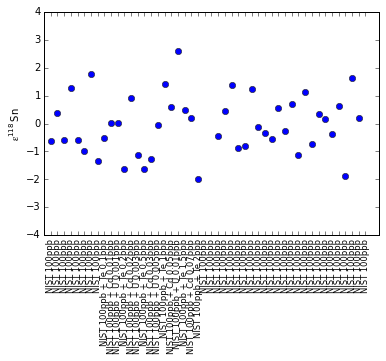

In [133]:
x = range(1, len(epsilon_comp["sample"])+1)
plot(x, epsilon_comp["112/120"], marker="o", ls="none")
ylim([-4, 4])
xticks(x, epsilon_comp["sample"], size='small', rotation=90)
ylabel(r'$\mathregular{\epsilon^{118}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [13]:
df_all.to_csv(path + "Sn_H8_L4_2_cycles_NU_Signals_zero_corr.csv", mode='a', header=False)

In [60]:
df_internal_norm.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_116_120_bdg_corr_with_outlier_rej_all.csv", mode='w', header=True)

In [51]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_116_120_bdg_corr_no_Xe_corr.csv", mode='w', header=True)

In [103]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

NameError: name 'df_std' is not defined

In [986]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [987]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [1088]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [30]:
#old Cd/Sn & Te/Sn extraction - doesn't include bgd corr
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "SQ") & (df_all["sample"] != "teflon blank")]
df_internal_sub["111"] = df_all_sub["L3 (1)"]
df_internal_sub["125"] = df_all_sub["H5 (2)"]
df_internal_sub["Cd/Sn"] = (df_all_sub["L3 (1)"]/12.722)/(df_all_sub["H4 (1)"]/24.223)
df_internal_sub["Te/Sn"] = (df_all_sub["H5 (2)"]/7.0509)/(df_all_sub["H4 (1)"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [1089]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date") 

In [1182]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 20:49:00,0.0298238495726,0.0201845997439,0.0103681594438,0.446,0.235295696368,0.742939518097,0.263445942562,0.142086185109,0.177571556759,10.1619395381,SPEX1 100ppb
2014-10-07 21:07:00,0.0298270855009,0.0201887834143,0.0103664239291,0.446,0.235295260593,0.742937654621,0.263447680516,0.14208571056,0.177573088542,10.2834847296,SPEX1 100ppb
2014-10-07 21:29:00,0.0298241010738,0.0201850728708,0.0103667030734,0.446,0.235295046713,0.742937732217,0.263449417694,0.142085954225,0.17757007419,10.0068814188,SPEX1 100ppb
2014-10-07 21:46:00,0.0298269719657,0.0201827454973,0.0103676568054,0.446,0.235297077525,0.742936157145,0.263450048386,0.142089277895,0.177573191934,10.1732362802,SPEX1 100ppb
2014-11-18 18:22:00,0.0298319477344,0.0201968060654,0.0103609914838,0.446,0.235308007067,0.74295144542,0.263456437295,0.142073025422,0.17753393783,11.9205622223,NIST 100ppb
2014-11-18 18:27:00,0.0298302415426,0.0202014506204,0.0103609667001,0.446,0.235304600881,0.742949759778,0.263451222795,0.142074064497,0.177531032284,11.8435340427,NIST 100ppb
2014-11-18 18:31:00,0.029834566445,0.0202024281122,0.0103608586407,0.446,0.235309236679,0.742955467382,0.263452936054,0.142073215452,0.177533064574,11.3634385069,NIST 100ppb
2014-11-18 18:36:00,0.0298236482085,0.0201946006554,0.0103617565758,0.446,0.235308318118,0.742946848523,0.263449990275,0.142074569672,0.177530832831,11.5416992302,NIST 100ppb
2014-11-18 18:40:00,0.0298227478429,0.0201921659888,0.0103615705949,0.446,0.235307461611,0.742950591745,0.263450041891,0.142075223065,0.177536326791,11.6314409578,NIST 100ppb


In [1183]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 18:49:00,0.029824,0.020185,0.010368,0.446,0.235296,0.742940,0.263446,0.142086,0.177572,10.161940,SPEX1 100ppb
2014-10-07 19:07:00,0.029827,0.020189,0.010366,0.446,0.235295,0.742938,0.263448,0.142086,0.177573,10.283485,SPEX1 100ppb
2014-10-07 19:29:00,0.029824,0.020185,0.010367,0.446,0.235295,0.742938,0.263449,0.142086,0.177570,10.006881,SPEX1 100ppb
2014-10-07 19:46:00,0.029827,0.020183,0.010368,0.446,0.235297,0.742936,0.263450,0.142089,0.177573,10.173236,SPEX1 100ppb
2014-11-18 17:22:00,0.029832,0.020197,0.010361,0.446,0.235308,0.742951,0.263456,0.142073,0.177534,11.920562,NIST 100ppb
2014-11-18 17:27:00,0.029830,0.020201,0.010361,0.446,0.235305,0.742950,0.263451,0.142074,0.177531,11.843534,NIST 100ppb
2014-11-18 17:31:00,0.029835,0.020202,0.010361,0.446,0.235309,0.742955,0.263453,0.142073,0.177533,11.363439,NIST 100ppb
2014-11-18 17:36:00,0.029824,0.020195,0.010362,0.446,0.235308,0.742947,0.263450,0.142075,0.177531,11.541699,NIST 100ppb
2014-11-18 17:40:00,0.029823,0.020192,0.010362,0.446,0.235307,0.742951,0.263450,0.142075,0.177536,11.631441,NIST 100ppb


In [1184]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [1220]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-11-18 18:54:00,-1.295126,-1.053575,1.608025,1.998401e-11,-1.180555,-0.463371,-0.356364,0.722133,2.010156,1309.494419,SPEX 100ppb
2014-12-06 22:37:00,-4.936059,-7.445774,1.331682,1.998401e-11,0.786625,0.539985,1.003885,0.222717,0.767402,-1614.119882,SPEX 100ppb
2014-12-06 22:52:00,-1.620072,-3.896472,0.536870,1.998401e-11,0.533814,0.527568,1.004705,0.469725,1.664357,-1804.778746,SPEX 100ppb
2014-12-06 23:08:00,-2.641746,-4.386719,2.125820,1.998401e-11,0.522416,0.475452,0.892735,0.462190,1.555222,-1848.039153,SPEX 100ppb
2014-12-06 23:23:00,-3.243182,-3.908338,-0.299309,1.998401e-11,0.613841,0.489401,0.951723,0.466426,1.660720,-1728.263406,SPEX 100ppb
2014-12-06 23:39:00,-3.174104,-5.626922,2.187946,1.998401e-11,0.711496,0.500329,0.913301,0.302836,1.500547,-1512.382276,SPEX 100ppb
2014-12-06 23:54:00,-2.499252,-3.686348,3.196847,1.998401e-11,0.532245,0.565307,0.943385,0.268384,1.570411,-1442.654967,SPEX 100ppb
2014-12-07 00:09:00,-3.167063,-4.997893,0.608021,1.998401e-11,0.745353,0.520016,1.039127,0.455542,1.559710,-1523.698889,SPEX 100ppb
2014-12-07 00:25:00,-2.027759,-4.105014,2.820000,1.998401e-11,0.605650,0.507195,0.913818,0.470145,1.538801,-1719.373397,SPEX 100ppb


In [1222]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,sample
0,-4.252887,1.76055,-2.836398,1.998401e-11,0.6046,0.052729,-0.550984,0.411199,1.946529,Lee et al. (1995)
